In [1]:
# Global
import jax.numpy as jnp
import numpy as np
import corner
import matplotlib.pyplot as plt


# Local
import examples_utils as eu
import fastPTA.utils as ut
from fastPTA.plotting_functions import my_colormap
from fastPTA.Fisher_code import compute_fisher
from fastPTA.signals import power_law_SIGW, power_law, SIGW

In [2]:
# Total observation time in years
T_obs_yrs = 10

# Number of frequencies used in the analysis
n_frequencies = 100

# Number of pulsars in the analysis
n_pulsars_1 = 100
n_pulsars_2 = 400

# Specify the type of noise to be used in the analysis
which_experiment = eu.mockSKA10

# Set the label to specify the signal model
signal_label = "power_law_SIGW"

# Current SMBBH SGWB log_amplitude best-fit
SMBBH_log_amplitude = -7.1995
SMBBH_tilt = 2

# The analysis assumes a power law template, specify here the input parameters
SIGW_log_amplitude = -1.7
SIGW_log_width = np.log10(0.5)
SIGW_log_pivot = -7.8

# Specify the true signal parameters
SMBBH_parameters = jnp.array([SMBBH_log_amplitude, SMBBH_tilt])

CGW_SIGW_parameters = jnp.array([SIGW_log_amplitude, SIGW_log_width, SIGW_log_pivot])

signal_parameters = np.concatenate([SMBBH_parameters, CGW_SIGW_parameters])

# Specify the labels for the signal parameters
parameter_labels=[
    r"$\alpha_{\rm PL}$",
    r"$n_{\rm T}$",
    r"${\rm log}_{10}A_\zeta$",
    r"${\rm log}_{10}\Delta$",
    r"${\rm log}_{10}(f_*/{\rm Hz})$",
]

# Number of points to generate for the Fisher
len_fisher_data = int(1e4)

# Name of the pulsar catalogue
outname_1 = "pulsar_configurations/PL+SIGW_1.txt"
outname_2 = "pulsar_configurations/PL+SIGW_2.txt"

# Paths of Fisher data 
path_to_Fisher_data_1="FIG1-2/Fisher_100_PL+SIGW.npz"
path_to_Fisher_data_2="FIG1-2/Fisher_400_PL+SIGW.npz"

In [3]:
# Dictionary with the kwargs to generete the pulsar catalogs
generate_catalog_kwargs_1 = {
    "n_pulsars": n_pulsars_1,
    "save_catalog": False,
    **which_experiment,
}

generate_catalog_kwargs_2 = {
    "n_pulsars": n_pulsars_2,
    "save_catalog": False,
    **which_experiment,
}

# Dictionary with the kwargs to generate noise and orf tensors
get_tensors_kwargs_1 = {
    "add_curn": False,
    "regenerate_catalog": True,
    "path_to_pulsar_catalog": outname_1,
}

get_tensors_kwargs_2 = {
    "add_curn": False,
    "regenerate_catalog": True,
    "path_to_pulsar_catalog": outname_2,
}

# Dictionary with the kwargs for the Fisher matrix
fisher_kwargs = {
    "T_obs_yrs": T_obs_yrs,
    "n_frequencies": n_frequencies,
    "signal_label": signal_label,
    "signal_parameters": signal_parameters,
}


In [4]:
if get_tensors_kwargs_1["regenerate_catalog"]:
    (
        frequency_1,
        signal_1,
        HD_functions_IJ_1,
        HD_coeffs_1,
        effective_noise_1,
        SNR_1,
        fisher_1,
    ) = compute_fisher(
        **fisher_kwargs,
        get_tensors_kwargs=get_tensors_kwargs_1,
        generate_catalog_kwargs=generate_catalog_kwargs_1,
    )

    covariance_1 = ut.compute_inverse(fisher_1)
    fisher_data_1 = np.random.multivariate_normal(
        signal_parameters, covariance_1, size=len_fisher_data
    )
    errors_1 = np.sqrt(np.diag(covariance_1))
else:
    Fisher_data_1 = np.load(path_to_Fisher_data_1)
    frequency_1 = Fisher_data_1["frequency"]
    effective_noise_1 = Fisher_data_1["effective_noise"]
    fisher_data_1 = Fisher_data_1["fisher"]


if get_tensors_kwargs_2["regenerate_catalog"]:
    (
        frequency_2,
        signal_2,
        HD_functions_IJ_2,
        HD_coeffs_2,
        effective_noise_2,
        SNR_2,
        fisher_2,
    ) = compute_fisher(
        **fisher_kwargs,
        get_tensors_kwargs=get_tensors_kwargs_2,
        generate_catalog_kwargs=generate_catalog_kwargs_2,
    )

    covariance_2 = ut.compute_inverse(fisher_2)
    fisher_data_2 = np.random.multivariate_normal(
        signal_parameters, covariance_2, size=len_fisher_data
    )
    errors_2 = np.sqrt(np.diag(covariance_2))
    print("Fisher errors", errors_2)
else: 
    Fisher_data_2 = np.load(path_to_Fisher_data_2)
    frequency_2 = Fisher_data_2["frequency"]
    effective_noise_2 = Fisher_data_2["effective_noise"]
    fisher_data_2 = Fisher_data_2["fisher"]

Fisher errors [0.01651864 0.05946593 0.19151644 0.18478897 0.1227226 ]


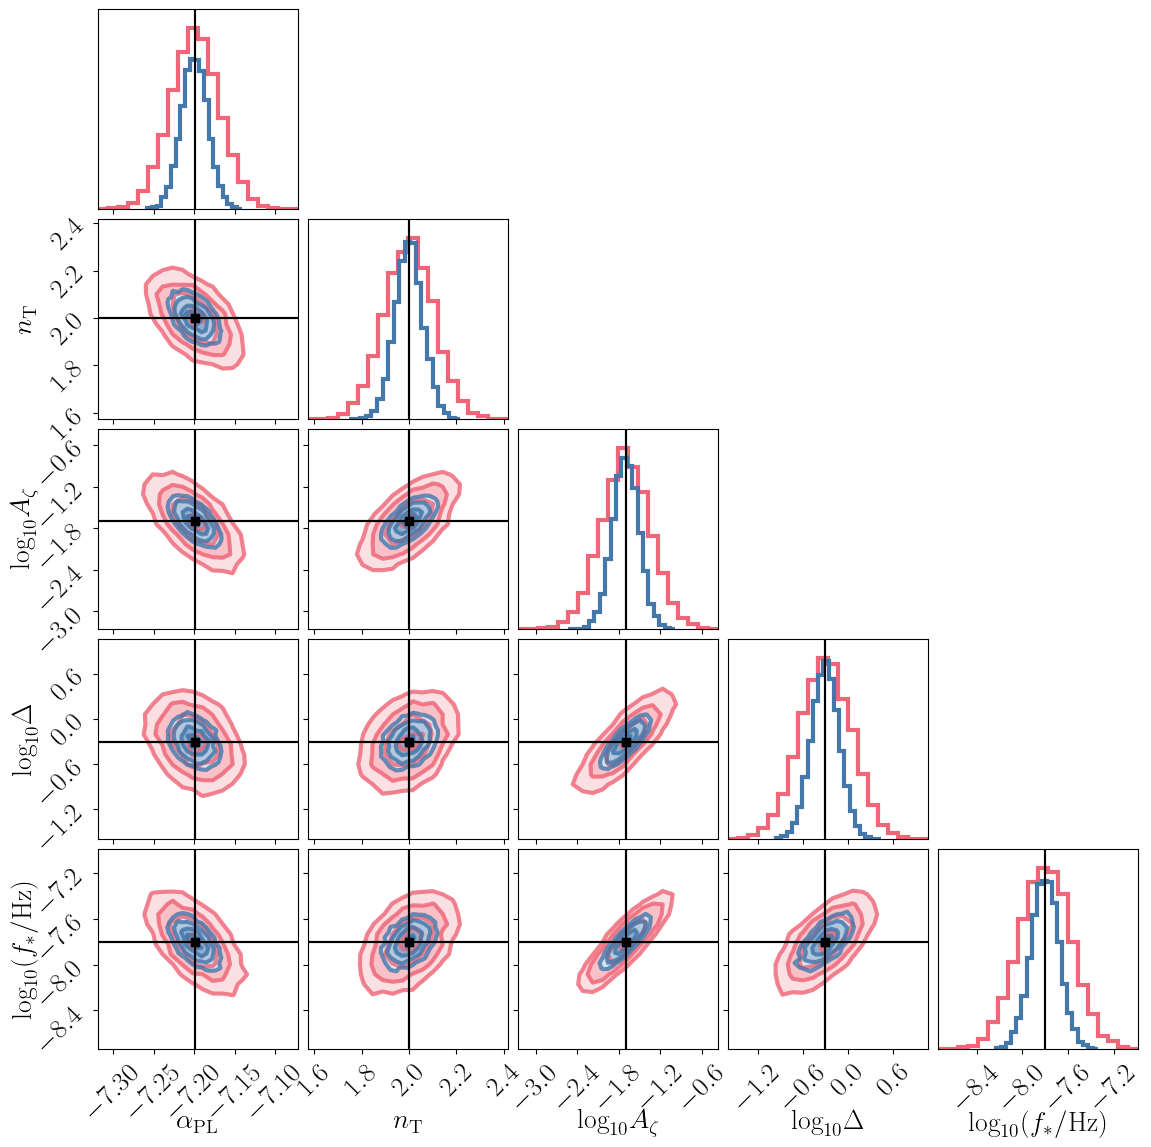

In [5]:
title_size = 10
widthlines_cont = 3
alpha_v = 0.8

figure = corner.corner(
    fisher_data_1,
    labels=parameter_labels,
    truths=signal_parameters,
    plot_datapoints=False,
    fill_contours=True,
    plot_contours=True,
    title_kwargs={"fontsize": title_size, "pad": 20},
    contour_kwargs={"linewidths": widthlines_cont, "alpha": alpha_v},
    hist_kwargs={"linewidth": widthlines_cont},
    color=my_colormap["red"],
    truth_color="black",
)

corner.corner(
    fisher_data_2,
    fig=figure,
    truths=signal_parameters,
    plot_datapoints=False,
    fill_contours=True,
    plot_contours=True,
    contour_kwargs={"linewidths": widthlines_cont, "alpha": alpha_v},
    hist_kwargs={"linewidth": widthlines_cont},
    color=my_colormap["blue"],
    truth_color="black",
)
    
plt.show(block=True)


In [9]:
# plot the SIGW_LN spectrum
x = np.logspace(np.log10(1 / 10 / ut.yr), -7, 500)
y = SIGW(x, CGW_SIGW_parameters)
yPL = power_law(x, SMBBH_parameters)

plt.loglog(
    frequency_1,
    effective_noise_1,
    label=r"${\rm S_{n,{\rm eff}}}(N_p = 100)$",
    color=my_colormap["red"],
    linewidth=2,
)
plt.loglog(
    frequency_2,
    effective_noise_2,
    label=r"${\rm S_{n,{\rm eff}}}(N_p = 400)$",
    color=my_colormap["blue"],
    linewidth=2,
)
plt.loglog(x, y, label=r"${\rm SIGW}$", color=my_colormap["purple"], linewidth=2)
plt.loglog(x, yPL, label=r"${\rm SMBH}$", color=my_colormap["green"], linewidth=2)
plt.xlabel(r"$f \ [{\rm Hz}]$")
plt.ylabel(r"$h^2 \Omega_{\rm GW}$")
plt.ylim(1e-11, 10**-5.5)
plt.xlim(1 / 10 / ut.yr, 1e-7)
plt.legend(loc=2, ncols=1)
plt.tight_layout()
plt.show(block=True)

NameError: name 'yr' is not defined